# 프로젝트 : CutMix or Mixup 비교실험

### 데이터 : stanford_dogs
- Augmentaion 적용x vs 적용 o
    - 좌우반전, 밝기 조절
- CutMix 적용x vs 적용 o
- Mixup 적용x vs 적용 o
### 모델 : ResNet50
- resnet50

## 0. 라이브러리

In [1]:
import pandas as pd
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# model,history save,load
import pickle

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Augmentation 적용한 데이터셋 생성
### 1.1 데이터 로드
- stanford_dogs

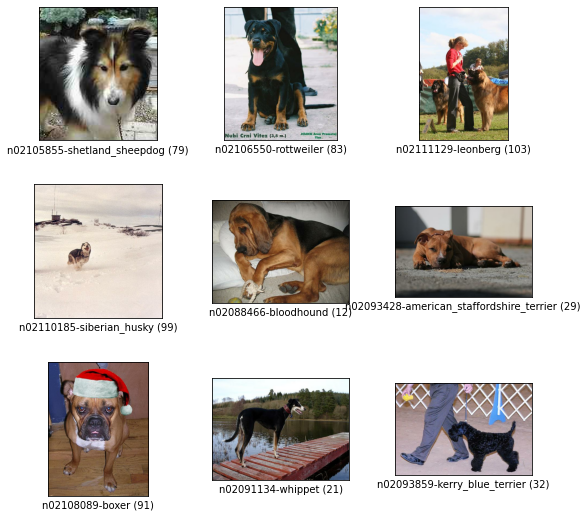

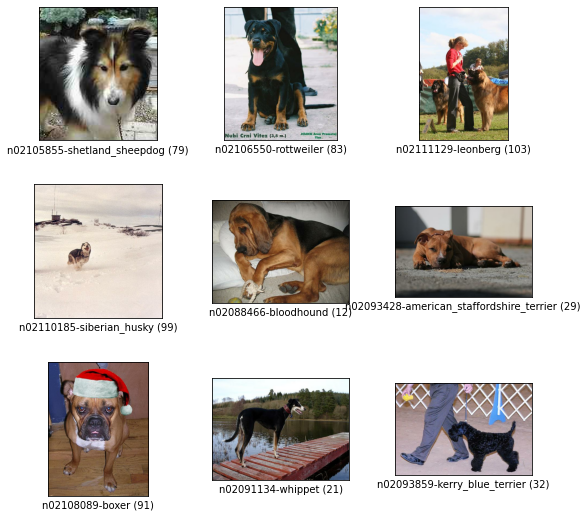

In [3]:
data_dir = '/aiffel/aiffel/aiffel_quest'

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir=data_dir
)
num_classes = ds_info.features['label'].num_classes
tfds.show_examples(ds_train, ds_info)

### 1.2 전처리 함수 정의

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

### 1.3 augment 함수 정의

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### 1.4 onthot 함수 정의

In [6]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### 2.1 cutmix 함수 정의

In [7]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)             # x 최소 좌표
    x_max = tf.math.minimum(image_size_x, x+width//2)  # x 최대 좌표
    y_min = tf.math.maximum(0, y-height//2)            # y 최소 좌표
    y_max = tf.math.minimum(image_size_y, y+height//2) # y 최대 좌표

    return x_min, x_max, y_min, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, x_max, y_min, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    bottom = image_a[0:y_min, :, :]
    top = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img


# 라벨 섞기
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, x_max, y_min, y_max, num_classes=num_classes):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

def cutmix(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=num_classes):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = images[j]
        label_b = labels[j]
        x_min, x_max, y_min, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, x_max, y_min, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, x_max, y_min, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 2.2 mixup 함수 정의

In [8]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    # ratio 비율 설정(lambda)
    ratio = tf.random.uniform([], 0, 1)
    # 원핫 인코딩
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    # 혼합  
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(images, labels, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = images[j]
        label_b = labels[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 3.1 데이터셋 가공 함수 정의
- 전처리
- augment
- cutmix
- mixup
- onehot
- shuffle

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        if with_cutmix:
            ds = ds.map(
                cutmix,
                num_parallel_calls=2
            )
        elif with_mixup:
            ds = ds.map(
                mixup,
                num_parallel_calls=2
            )
        else:
            ds = ds.map(
            onehot,
            num_parallel_calls=2
            )
        ds = ds.repeat()
        ds = ds.shuffle(200)
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 3.2 Augmentation 적용을 위한 데이터 준비

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)

ds_train_no_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True, with_mixup=False)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)

ds_train_no_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 3.3 데이터의 적용 증강 비교

In [11]:
data = {
    'Data Set': [
        'ds_train_no_aug', 'ds_train_aug', 'ds_train_no_aug_cutmix', 
        'ds_train_aug_cutmix', 'ds_train_no_aug_mixup', 'ds_train_aug_mixup', 'ds_test'
    ],
    'normalize_and_resize_img': ['Yes'] * 7,
    'augment': ['No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No'],
    'cutmix': ['No', 'No', 'Yes', 'Yes', 'No', 'No', 'No'],
    'mixup': ['No', 'No', 'No', 'No', 'Yes', 'Yes', 'No'],
    'onehot': ['Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes'],
    'repeat': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No'],
    'shuffle': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No'],
    'prefetch': ['Yes'] * 7
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 데이터프레임 출력
df

,Data Set,normalize_and_resize_img,augment,cutmix,mixup,onehot,repeat,shuffle,prefetch
0,ds_train_no_aug,Yes,No,No,No,Yes,Yes,Yes,Yes
1,ds_train_aug,Yes,Yes,No,No,Yes,Yes,Yes,Yes
2,ds_train_no_aug_cutmix,Yes,No,Yes,No,No,Yes,Yes,Yes
3,ds_train_aug_cutmix,Yes,Yes,Yes,No,No,Yes,Yes,Yes
4,ds_train_no_aug_mixup,Yes,No,No,Yes,No,Yes,Yes,Yes
5,ds_train_aug_mixup,Yes,Yes,No,Yes,No,Yes,Yes,Yes
6,ds_test,Yes,No,No,No,Yes,No,No,Yes


### 3.4 데이터 증강 적용 확인

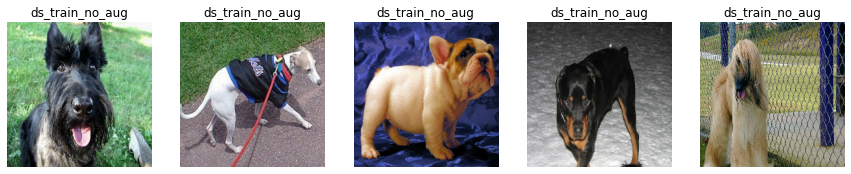

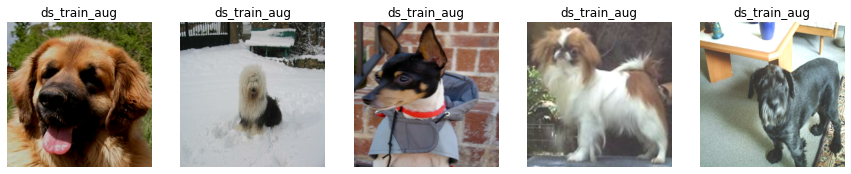

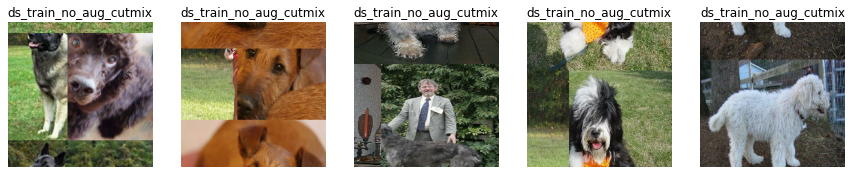

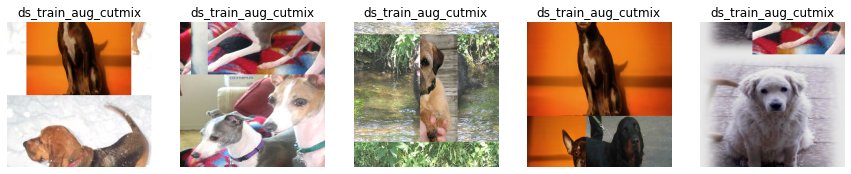

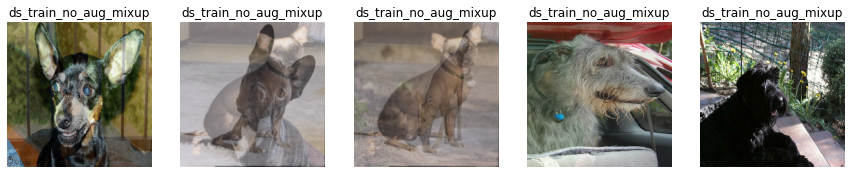

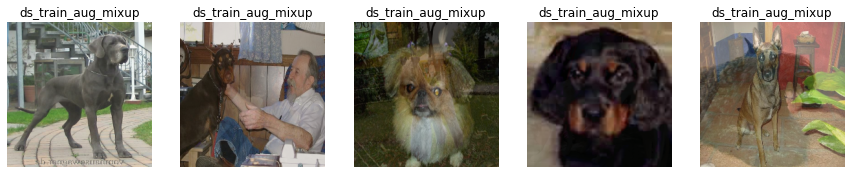

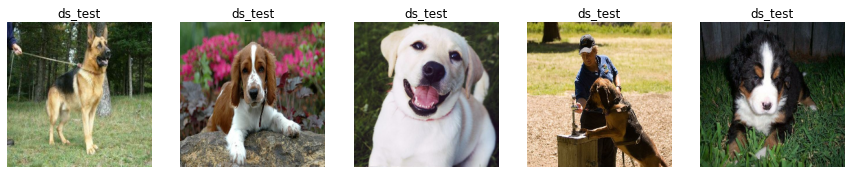

In [12]:
def plot_images_from_dataset(ds, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for images, labels in ds.take(1):  # Take one batch from the dataset
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())  # 이미지를 [0,1] 범위로 normalize했으므로 변환 불필요
            plt.title(title)
            plt.axis("off")
    plt.show()
plot_images_from_dataset(ds_train_no_aug, "ds_train_no_aug")
plot_images_from_dataset(ds_train_aug, "ds_train_aug")

plot_images_from_dataset(ds_train_no_aug_cutmix, "ds_train_no_aug_cutmix")
plot_images_from_dataset(ds_train_aug_cutmix, "ds_train_aug_cutmix")

plot_images_from_dataset(ds_train_no_aug_mixup, "ds_train_no_aug_mixup")
plot_images_from_dataset(ds_train_aug_mixup, "ds_train_aug_mixup")

plot_images_from_dataset(ds_test, "ds_test")

## 4. 모델 생성
### 4.1 증강 별 모델 정의

In [11]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
    ])

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
no_aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
no_aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 4.2 모델 학습

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest2/models/'

# no_aug_resnet50 모델 저장 (아무것도 적용하지 않은 데이터셋 사용)
no_aug_resnet50.save(drive_path + 'no_aug_resnet50.h5')

with open(drive_path + 'history_no_aug_resnet50.pkl', 'wb') as f:
    pickle.dump(history_no_aug_resnet50.history, f)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20


In [ ]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest2/models/'
# aug_resnet50 모델 저장 (augmentation 적용한 데이터셋 사용)
aug_resnet50.save(drive_path + 'aug_resnet50.h5')

with open(drive_path + 'history_aug_resnet50.pkl', 'wb') as f:
    pickle.dump(history_aug_resnet50.history, f)

In [ ]:
no_aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_no_aug_cutmix_resnet50 = no_aug_cutmix_resnet50.fit(
    ds_train_no_aug_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# no_aug_cutmix_resnet50 모델 저장 (augmentation x, cutmix 적용한 데이터셋 사용)
no_aug_cutmix_resnet50.save(drive_path + 'no_aug_cutmix_resnet50.h5')

with open(drive_path + 'history_no_aug_cutmix_resnet50.pkl', 'wb') as f:
    pickle.dump(history_no_aug_cutmix_resnet50.history, f)

In [20]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_cutmix_resnet50 = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest2/models/'
# aug_cutmix_resnet50 모델 저장 (augmentation, cutmix 적용한 데이터셋 사용)
aug_cutmix_resnet50.save(drive_path + 'aug_cutmix_resnet50.h5')

with open(drive_path + 'history_aug_cutmix_resnet50.pkl', 'wb') as f:
    pickle.dump(history_aug_cutmix_resnet50.history, f)

Epoch 1/20
750/750 [==============================] - 162s 200ms/step - loss: 3.9371 - accuracy: 0.1836 - val_loss: 3.4096 - val_accuracy: 0.2091
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 3.0670 - accuracy: 0.3834 - val_loss: 1.5194 - val_accuracy: 0.6027
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.7953 - accuracy: 0.4585 - val_loss: 1.3230 - val_accuracy: 0.6272
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6374 - accuracy: 0.5104 - val_loss: 1.2364 - val_accuracy: 0.6669
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5102 - accuracy: 0.5453 - val_loss: 1.2400 - val_accuracy: 0.6559
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.4108 - accuracy: 0.5760 - val_loss: 1.1732 - val_accuracy: 0.6837
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3406 - accuracy: 0.6003 - val_loss: 1.3049 -

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
no_aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_no_aug_mixup_resnet50 = no_aug_mixup_resnet50.fit(
    ds_train_no_aug_mixup, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest2/models/'
# no_aug_cutmix_resnet50 모델 저장 (augmentation x, mixup 적용한 데이터셋 사용)
no_aug_mixup_resnet50.save(drive_path + 'no_aug_mixup_resnet50.h5')

with open(drive_path + 'history_no_aug_mixup_resnet50.pkl', 'wb') as f:
    pickle.dump(history_no_aug_mixup_resnet50.history, f)

NameError: name 'no_aug_mixup_resnet50' is not defined

In [22]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_mixup_resnet50 = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# no_aug_cutmix_resnet50 모델 저장 (augmentation , mixup 적용한 데이터셋 사용)
aug_mixup_resnet50.save(drive_path + 'aug_mixup_resnet50.h5')

with open(drive_path + 'history_aug_mixup_resnet50.pkl', 'wb') as f:
    pickle.dump(history_aug_mixup_resnet50.history, f) 

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.7685 - accuracy: 0.2324 - val_loss: 3.7050 - val_accuracy: 0.1595
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9278 - accuracy: 0.4548 - val_loss: 1.4937 - val_accuracy: 0.5722
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6735 - accuracy: 0.5443 - val_loss: 1.3789 - val_accuracy: 0.6151
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5010 - accuracy: 0.6059 - val_loss: 1.3571 - val_accuracy: 0.6248
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3596 - accuracy: 0.6633 - val_loss: 1.2702 - val_accuracy: 0.6600
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 2.2981 - accuracy: 0.6862 - val_loss: 1.2808 - val_accuracy: 0.6468
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1889 - accuracy: 0.7252 - val_loss: 1.2495 -

In [11]:
ds_train_aug_cutmix_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=True)

aug_cutmix_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


aug_cutmix_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

94781440/94765736 [==============================] - 0s 0us/step


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
history_aug_cutmix_mixup_resnet50 = aug_cutmix_mixup_resnet50.fit(
    ds_train_aug_cutmix_mixup, # cutmix 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest2/models/'
# no_aug_cutmix_resnet50 모델 저장 (augmentation , mixup 적용한 데이터셋 사용)
aug_cutmix_mixup_resnet50.save(drive_path + 'aug_cutmix_mixup_resnet50.h5')

with open(drive_path + 'history_aug_cutmix_mixup_resnet50.pkl', 'wb') as f:
    pickle.dump(history_aug_cutmix_mixup_resnet50.history, f) 

Epoch 1/20
750/750 [==============================] - 207s 204ms/step - loss: 3.9481 - accuracy: 0.1737 - val_loss: 3.7424 - val_accuracy: 0.1493
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 3.0838 - accuracy: 0.3785 - val_loss: 1.5651 - val_accuracy: 0.5677
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.8334 - accuracy: 0.4456 - val_loss: 1.4521 - val_accuracy: 0.6087
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6476 - accuracy: 0.5077 - val_loss: 1.3371 - val_accuracy: 0.6323
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 2.5263 - accuracy: 0.5418 - val_loss: 1.3279 - val_accuracy: 0.6224
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 2.4238 - accuracy: 0.5730 - val_loss: 1.1783 - val_accuracy: 0.6704
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 2.3451 - accuracy: 0.5937 - val_loss: 1.2601 -

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
